In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pyvista as pv
mesh = pv.read("~/code/uni/ushichka-registration/data/formatted/lidar_roi.ply")

pl = pv.Plotter(off_screen=False, notebook=False)
pl.add_mesh(mesh)
points = []
def onclick(point):
    points.append(point)
    print(f"picked {point}")
pl.enable_surface_picking(callback=onclick)
pl.show()

In [3]:
import numpy as np
points = np.array(points)
points

array([], dtype=float64)

In [4]:
picked_points = np.array([[-3.02017072,  1.91602907, -0.76811603],
       [-2.94146387,  1.97436807, -0.76497208],
       [-2.79947306,  2.0846709 , -0.7584722 ],
       [-2.95145778,  1.86817301, -0.93618609],
       [-2.88422545,  1.95260004, -0.94004291],
       [-2.79349747,  2.01736747, -0.94137936],
       [-2.90292026,  2.15166943, -0.804179  ],
       [-2.94026855,  2.20932992, -0.8097752 ],
       [-2.88185829,  2.13162774, -0.98856108],
       [-2.92712112,  2.21133655, -0.98735138]])

picked_cloud = pv.PolyData(picked_points)
picked_cloud["index"] = [f"{i}" for i in range(picked_points.shape[0])]
pl = pv.Plotter(off_screen=False, notebook=False)
pl.add_mesh(mesh)
pl.add_mesh(picked_cloud, color="green", point_size=25)
pl.add_point_labels(picked_cloud, "index", point_size=5, font_size=36)
points = []
def onclick(point):
    points.append(point)
    print(f"picked {point}")
pl.enable_surface_picking(callback=onclick)
pl.show()

In [6]:
from src.pycv.dmcp import dm_to_world
from src.experiment import Experiment
import scipy.linalg as la
exp = Experiment("/home/julian/data/dmcp_experiments/round_02/2018-08-19--cam1")
dmIm = exp.load_dmIm()
dmK = exp.load_dmK()
dmP = exp.load_dmP()
la.null_space(dmP) / la.null_space(dmP)[-1]

array([[-0.12298417],
       [ 2.07548531],
       [-0.18351529],
       [ 1.        ]])

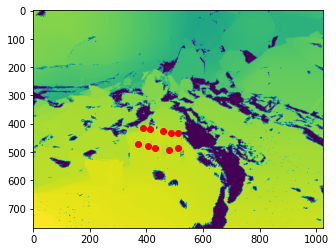

In [7]:
# observe picked points with dmP
picked_points_hat = np.hstack((picked_points,np.ones((picked_points.shape[0],1))))

projected_points = dmP @ picked_points_hat.T
projected_points = projected_points.T 
projected_points = np.array([projected_points[:,0] / projected_points[:,-1], projected_points[:,1] / projected_points[:,-1]]).T

import matplotlib.pyplot as plt

plt.imshow(dmIm, origin="upper",cmap="viridis_r")
plt.scatter(projected_points[:,0], projected_points[:,1],color="red")
plt.show()

In [8]:
from src.pycv.perspective import calibrate_dlt

P_calib = calibrate_dlt(projected_points, picked_points)
import scipy.linalg as la
la.null_space(P_calib) / la.null_space(P_calib)[-1]

array([[-0.12298417],
       [ 2.07548531],
       [-0.18351529],
       [ 1.        ]])

In [9]:
dm_to_world(dmIm, dmK, dmP, dmPts=projected_points)

array([[-3.0347853 ,  1.9152247 , -0.771065  ],
       [-2.9563813 ,  1.9738328 , -0.76804954],
       [-2.8402815 ,  2.084811  , -0.76723856],
       [-2.9736338 ,  1.8665476 , -0.94208723],
       [-2.9280736 ,  1.9506487 , -0.95205647],
       [-2.8148036 ,  2.0169039 , -0.94742584],
       [-2.788659  ,  2.148538  , -0.77866846],
       [-2.9294362 ,  2.2088153 , -0.80736727],
       [-3.4204364 ,  2.1425877 , -1.1457194 ],
       [-2.9270315 ,  2.2113323 , -0.9873257 ]], dtype=float32)

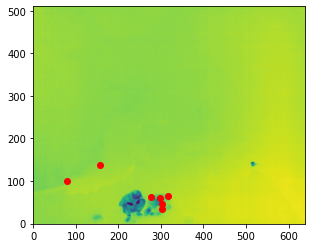

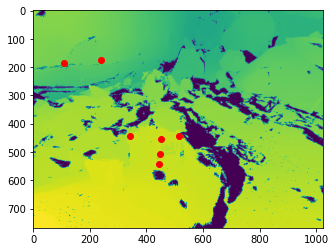

In [39]:
from src.pycv.dmcp import dmcp

imK = exp.load_imK()
imP = exp.load_imP()
imIm = exp.load_imIm()
cps = exp.load_cps()

plt.figure()
plt.imshow(imIm, cmap="viridis_r",origin="lower")
plt.scatter(cps[:,0],cps[:,1],c="red")
plt.show()

plt.figure()
plt.imshow(dmIm, cmap="viridis_r")
plt.scatter(cps[:,2],cps[:,3],c="red")
plt.show()



In [40]:
cps_world = dm_to_world(dmIm, dmK, dmP, cps[:,2:])
cps_world

array([[-2.9781823 ,  1.8014587 , -0.8486274 ],
       [-2.779315  ,  2.064565  , -0.8345605 ],
       [-2.9388795 ,  2.2211971 , -0.8438163 ],
       [-2.8147888 ,  2.0410836 , -1.130751  ],
       [-5.3758483 ,  0.63971406,  0.10670515],
       [-5.7911015 ,  1.130159  ,  0.19022453],
       [-2.8265831 ,  2.0532677 , -1.0176207 ]], dtype=float32)

In [48]:
P_calib = calibrate_dlt(cps[:,:2], cps_world)

print("dlt calib")
la.null_space(P_calib) / la.null_space(P_calib)[-1]

dlt calib


array([[-2.82250013],
       [ 2.03984044],
       [-1.10155524],
       [ 1.        ]])

In [69]:
from src.pycv.perspective import solve_PnP
P_calib = solve_PnP(cps_world, cps[:,:2], imK)

print("solve pnp calib")
la.null_space(P_calib) / la.null_space(P_calib)[-1]

[[ 1.21690866]
 [ 1.52648315]
 [-1.07637543]]
[[-2.50809189]
 [-2.41001196]
 [ 2.49703012]]
solve pnp calib


array([[-2.50809189],
       [-2.41001196],
       [ 2.49703012],
       [ 1.        ]])

project cps into depth map is working:

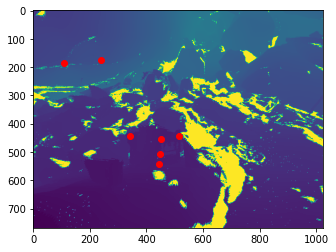

In [43]:
p_world_hat = np.hstack((cps_world,np.ones((cps_world.shape[0], 1))))

reprojs = dmP @ p_world_hat.T
reprojs = reprojs.T

reprojs = np.array([ reprojs[:,0] / reprojs[:,-1], reprojs[:,1] / reprojs[:,-1]  ]).T
reprojs

plt.imshow(dmIm)
plt.scatter(reprojs[:,0],reprojs[:,1],color="red")

however calibrated pose seems not valid

[[ 4.22437981  0.48172759 -3.32767911]
 [ 4.24266459  0.71392861 -3.56160073]
 [ 4.30716148  0.58032595 -3.72914361]
 [ 4.52840321  0.70559747 -3.4731552 ]
 [ 3.36028489 -2.14237424 -2.71242092]
 [ 3.44240916 -2.48903427 -3.25374278]
 [ 4.42330908  0.68429377 -3.51299748]]
[[-1.2694673  -0.14476383]
 [-1.19122409 -0.20045161]
 [-1.15500016 -0.15561909]
 [-1.30382979 -0.20315748]
 [-1.23885082  0.78983841]
 [-1.05798442  0.76497573]
 [-1.25912675 -0.19478914]]


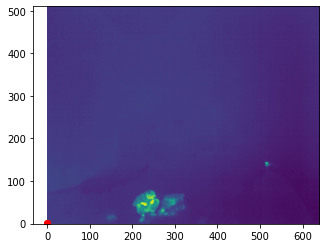

In [73]:

reprojs = P_calib @ p_world_hat.T
reprojs = reprojs.T
reprojs = np.array([ reprojs[:,0] / reprojs[:,-1], reprojs[:,1] / reprojs[:,-1]  ]).T

plt.imshow(imIm, origin="lower")
plt.scatter(reprojs[:,0],reprojs[:,1],color="red")

In [66]:
A = dmcp(imK, imP, cps[:,:2], cps_world)
A

[[ 1.21690866]
 [ 1.52648315]
 [-1.07637543]]
[[-2.50809189]
 [-2.41001196]
 [ 2.49703012]]
estimated pose
[[-2.50809189]
 [-2.41001196]
 [ 2.49703012]
 [ 1.        ]]


array([[ -0.15247685,   0.65771875,   0.73766988,  23.58920025],
       [ -0.93160199,  -0.34484062,   0.1149029 ,   8.52192773],
       [  0.32995233,  -0.6696947 ,   0.66531231, -17.67330919],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

#### analyze result

In [50]:
# transfer
P_trans = imP @ la.inv(A)

la.null_space(P_trans) / la.null_space(P_trans)[-1]


array([[30.40066536],
       [-2.7114245 ],
       [ 9.74890543],
       [ 1.        ]])